In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mep = pd.read_csv('retweets.csv')

In [ ]:
mep.shape

In [ ]:
mep.columns

Delete the records with not English languages

In [ ]:
mep.lang

In [ ]:
mep = mep.loc[mep.lang == 'en']

In [ ]:
import tweepy
auth = tweepy.OAuthHandler('hsaHW0P7kFtP7yiOTWV6E5Cmz', 'A1fgwDsjBQ48dYM8xHqq1fafs8sJpOAj9m9QFkEmqBjorpEk4X')

In [ ]:
mep

In [ ]:
origTweetList = mep.origTweetId.tolist()

In [ ]:
try:
    redirect_url = auth.get_authorization_url()
except tweepy.TweepError:
    print('Error! Failed to get request token.')

In [ ]:
# api = tweepy.API(auth)
# origText = []
# for tweetid in origTweetList:
#     try:
#         tweet = api.get_status(tweetid)
#         origText.append(tweet.text)
#         print(tweet.text)
#     except:
#         origText.append('')
#         print(' ')

https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy

In [ ]:
import tweepy

import time

t0 = time.time()

def lookup_tweets(tweet_IDs, api):
    full_tweets = []
    tweet_count = len(tweet_IDs)
    try:
        for i in range((tweet_count // 100) + 1):
            # Catch the last group if it is less than 100 tweets
            end_loc = min((i + 1) * 100, tweet_count)
            full_tweets.extend(
                api.statuses_lookup(id_=tweet_IDs[i * 100:end_loc])
            )  
        return full_tweets
    except tweepy.TweepError:
        print('Something went wrong, quitting...')

auth = tweepy.OAuthHandler('hsaHW0P7kFtP7yiOTWV6E5Cmz', 'A1fgwDsjBQ48dYM8xHqq1fafs8sJpOAj9m9QFkEmqBjorpEk4X')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# do whatever it is to get por.TweetID - the list of all IDs to look up

results = lookup_tweets(origTweetList, api)

final_dic = {}

t1 = time.time()
total = t1-t0
print(total)

In [ ]:
for tweet in results:
    if tweet:
        final_dic[tweet.id] = tweet.text

In [ ]:
import pprint
# pprint.pprint(final_dic)
len(final_dic)

In [ ]:
tweet_text = pd.DataFrame.from_dict(final_dic, orient='index', columns=['tweetText'])

## Cross Validate that the number of rows is **10126**

### Something to investigate: Do we have duplicate tweets on the dataset?
### mep rows: 13796
### mep.origTweetId.unique(): 10834

In [ ]:
len(mep.origTweetId.unique())

In [ ]:
tweet_text

In [ ]:
mepExt = pd.merge(mep, tweet_text, left_on='origTweetId', right_index=True, how='inner')

In [ ]:
group = mepExt.groupby('origMepGroupShort').count()
groupFiltered = group.loc[group.origUserId > 50]
mepExt = mepExt.loc[mepExt.origMepGroupShort.isin(list(groupFiltered.index))]

In [ ]:
mepExt

In [ ]:
export = mepExt.to_csv(r'C:\Users\Ion\Documents\GitHub\Clustering-and-Classification-of-MEPs-Tweets\fullRetweets.csv',  index = None, header=True)

## Finish the clearing part -- Exporting the CSV so I don't need to run the proccess over and over again

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", 30)
%matplotlib inline

fullRetweets = pd.read_csv('FullRetweets.csv')

In [3]:
fullRetweets

,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang,tweetText
0,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en,Euro Parliament votes overwhelmingly to reject...
1,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,124965,Nathan GILL,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en,"US have one currency, one Central Bank and one..."
2,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,96672,Marita ULVSKOG,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en,More jobs for young people is my top priority ...
3,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Thu Dec 04 22:21:10 +0000 2014,540631925145493504,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
4,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Sun Mar 29 18:53:32 +0000 2015,582254277122473984,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12903,1485429175,JSaryuszWolski,28297,Jacek SARYUSZ-WOLSKI,4,EPP,20,POL,539156512,ZdzKrasnodebski,124891,Zdzisław KRASNODĘBSKI,5,ECR,20,POL,Sun Jan 24 13:17:25 +0000 2016,691248438504210432,Mon Jan 25 08:21:14 +0000 2016,691536290198745088,en,Drastic drop in positive EU perception in Pola...
12904,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,1354570123,julie4nw,124963,Julie WARD,1,S&D,27,GBR,Sun Jan 24 14:04:13 +0000 2016,691260217288454144,Sun Jan 24 14:54:31 +0000 2016,691272874393485314,en,I'm with @UKYP North West now in Knowsley - gr...
12905,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,202610289,akhanmep,124962,Afzal KHAN,1,S&D,27,GBR,Sun Jan 24 14:12:29 +0000 2016,691262296396599296,Sun Jan 24 14:21:13 +0000 2016,691264493725335552,en,Listening to some fab ideas from young people ...
12906,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,1354570123,julie4nw,124963,Julie WARD,1,S&D,27,GBR,Sun Jan 24 14:12:29 +0000 2016,691262296396599296,Sun Jan 24 14:54:26 +0000 2016,691272856739659776,en,Listening to some fab ideas from young people ...


## Remember to do something with word clouds
https://github.com/amueller/word_cloud

In [4]:
import wordcloud
import matplotlib
import PIL

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

# another set of stopwords

from nltk.corpus import stopwords
import nltk
import sklearn as sk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [6]:
clean_text = fullRetweets.tweetText.drop_duplicates()

In [7]:
corpus = list(clean_text)

In [8]:
from sklearn.feature_extraction import text 

my_additional_stop_words = ['http', 'https', 'amp', 'timmermans', 'timkirkhopemep', 'etuc_ces', 'kurdish', 'europe', 'eu', 'ep', 'european', 'parliament']

stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [9]:
my_stop_words = set(stopwords.words('english')) 
vectorizer = CountVectorizer(lowercase=True, min_df=10, max_df=0.6, stop_words = stop_words)
X = vectorizer.fit_transform(corpus)
X.shape
# vectorizer2 = TfidfVectorizer(lowercase=True, min_df=10, max_df=0.5, stop_words='english')
# X2 = vectorizer2.fit_transform(corpus)

(10102, 1938)

In [23]:
kmeans = KMeans(n_clusters=5).fit(X)

In [24]:
cluster_labels = kmeans.fit_predict(X)

In [25]:
metrics.silhouette_score(X, labels=cluster_labels)

0.03383675873338323

In [27]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(5):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :15]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: gt russia ukraine new good policy russian countries people day deal council defence democracy vote
Cluster 1: uk meps just labour vote today ttip support voted work great new eurolabour people good
Cluster 2: today eppgroup people good need great meeting new ttip vote support greece europarl_en theprogressives right
Cluster 3: ukip vote labour today party people nhs uk policy immigration just tories lab meps election
Cluster 4: debate speech today great ttip live europarl_en digital vote good need mep plenary people epp


In [ ]:
Y = vectorizer.transform(["brexit is coming"])
prediction = kmeans.predict(Y)
print(prediction)

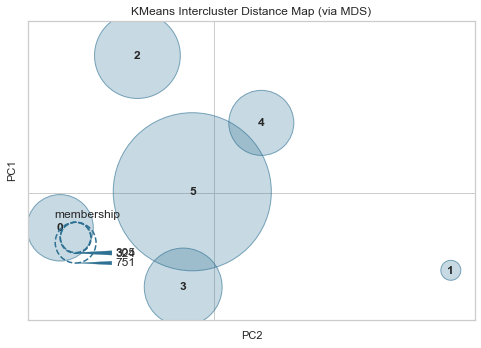

In [29]:
from yellowbrick.cluster import InterclusterDistance
model = KMeans(6)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

C:\Users\Ion\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Ion\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


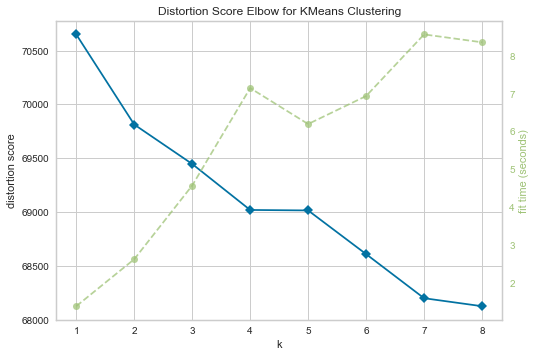

In [19]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,9))

visualizer.fit(X)
visualizer.show()

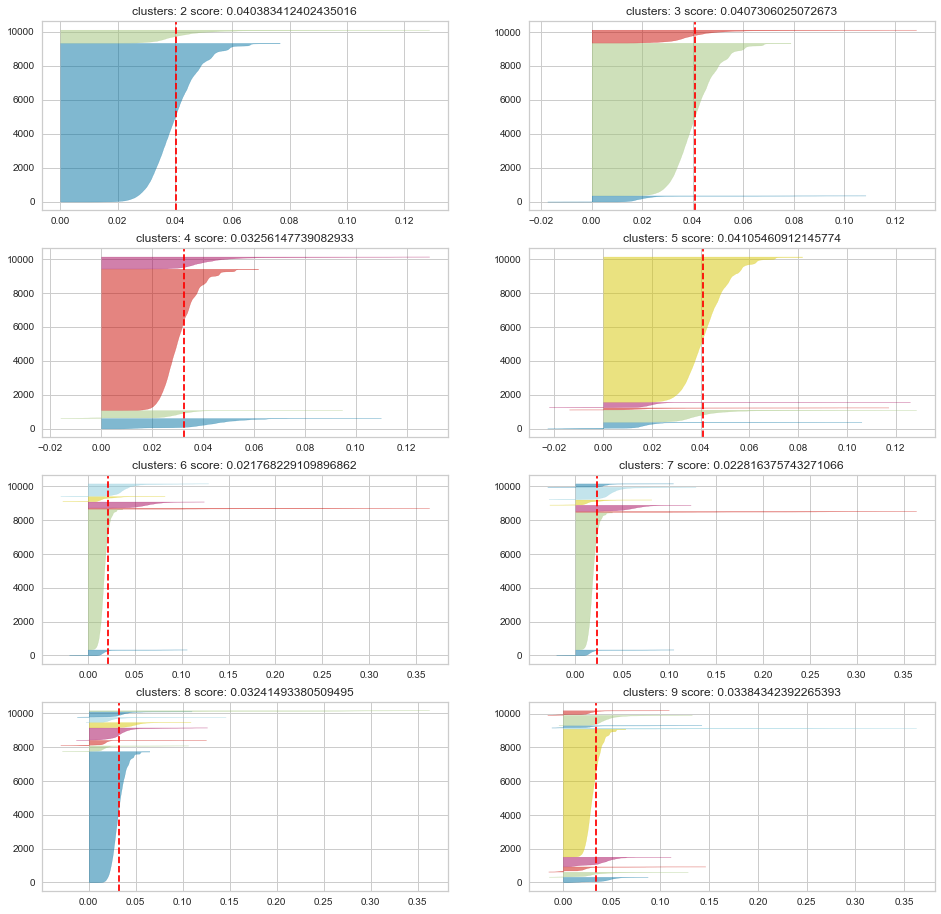

In [20]:
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2, 10):
    plt.subplot(4, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [21]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(5, 0.04105460912145774),
 (3, 0.0407306025072673),
 (2, 0.040383412402435016),
 (9, 0.03384342392265393),
 (4, 0.03256147739082933),
 (8, 0.03241493380509495),
 (7, 0.022816375743271066),
 (6, 0.021768229109896862)]

## Classification

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", 30)
%matplotlib inline

fullRetweets = pd.read_csv('FullRetweets.csv')

In [2]:
fullRetweets

,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang,tweetText
0,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en,Euro Parliament votes overwhelmingly to reject...
1,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,124965,Nathan GILL,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en,"US have one currency, one Central Bank and one..."
2,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,96672,Marita ULVSKOG,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en,More jobs for young people is my top priority ...
3,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Thu Dec 04 22:21:10 +0000 2014,540631925145493504,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
4,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Sun Mar 29 18:53:32 +0000 2015,582254277122473984,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12903,1485429175,JSaryuszWolski,28297,Jacek SARYUSZ-WOLSKI,4,EPP,20,POL,539156512,ZdzKrasnodebski,124891,Zdzisław KRASNODĘBSKI,5,ECR,20,POL,Sun Jan 24 13:17:25 +0000 2016,691248438504210432,Mon Jan 25 08:21:14 +0000 2016,691536290198745088,en,Drastic drop in positive EU perception in Pola...
12904,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,1354570123,julie4nw,124963,Julie WARD,1,S&D,27,GBR,Sun Jan 24 14:04:13 +0000 2016,691260217288454144,Sun Jan 24 14:54:31 +0000 2016,691272874393485314,en,I'm with @UKYP North West now in Knowsley - gr...
12905,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,202610289,akhanmep,124962,Afzal KHAN,1,S&D,27,GBR,Sun Jan 24 14:12:29 +0000 2016,691262296396599296,Sun Jan 24 14:21:13 +0000 2016,691264493725335552,en,Listening to some fab ideas from young people ...
12906,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,1354570123,julie4nw,124963,Julie WARD,1,S&D,27,GBR,Sun Jan 24 14:12:29 +0000 2016,691262296396599296,Sun Jan 24 14:54:26 +0000 2016,691272856739659776,en,Listening to some fab ideas from young people ...


In [3]:
classif_tweets = fullRetweets[['tweetText', 'origMepGroupShort']]

In [5]:
classif_tweets = classif_tweets.drop_duplicates()

In [6]:
classif_tweets

,tweetText,origMepGroupShort
0,Euro Parliament votes overwhelmingly to reject...,EFDD
1,"US have one currency, one Central Bank and one...",S&D
2,More jobs for young people is my top priority ...,S&D
3,"Vote #Labour, get Tory. Vote Tory, get Labour....",EFDD
5,Answering my question in ECR Group J-C Juncker...,ECR
...,...,...
12901,Time to lock EU leaders in a room to sort #ref...,ALDE
12903,Drastic drop in positive EU perception in Pola...,EPP
12904,I'm with @UKYP North West now in Knowsley - gr...,S&D
12905,Listening to some fab ideas from young people ...,S&D


Let's first investigate the balance of different tweets between the different political parties.

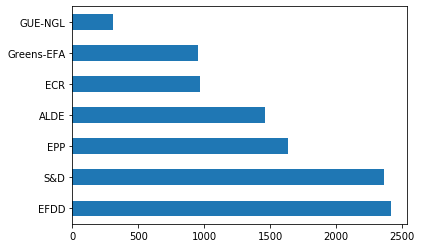

In [10]:
classif_tweets.origMepGroupShort.value_counts().plot(kind='barh')
plt.show()

* We notice that the data are quite unbalanced, might have to think what we should do about that
* Let's create a ```dummy classifier``` who's score will be our threshold

In [14]:
X = classif_tweets.tweetText
y = classif_tweets.origMepGroupShort
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)

array(['EFDD', 'EFDD', 'EFDD', ..., 'EFDD', 'EFDD', 'EFDD'], dtype='<U4')

In [15]:
dummy_clf.score(X, y)

0.23935854286279945

We have to create a **bag of words** is which we will do the classification

In [22]:
my_tags = list(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.49620587264929067


ValueError: Number of classes, 7, does not match size of target_names, 10102. Try specifying the labels parameter